In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt

#Set random_seed for reproducible result
RANDOM_SEED = np.random.seed(0)
#Import our data
df = pd.read_csv('weekly-fuel-prices-in-italy.csv',sep=';')
df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,2022-10-31,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [4]:
# Step 1: Data Cleaning
df.dropna(inplace=True)  # remove any rows with missing values
df = df[df['PRICE'] > 0]  # remove any rows with negative or zero prices
df

,SURVEY_DATE,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
0,2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
1,2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2,2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
3,2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
4,2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...,...
5353,2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
5354,2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
5355,2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45
5356,2022-10-31,6,Residual fuel oil,1223.00,111.18,166.84,944.98,-1.91


In [5]:
# Step 2: Convert the 'date' column to a datetime object and set it as the index
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])
df.set_index('SURVEY_DATE', inplace=True)
df

,PRODUCT_ID,PRODUCT_NAME,PRICE,VAT,EXCISE,NET,CHANGE
SURVEY_DATE,,,,,,,
2005-01-03,1,Euro-Super 95,1115.75,185.96,558.64,371.15,-1.57
2005-01-03,2,Automotive gas oil,1018.28,169.71,403.21,445.36,-0.33
2005-01-03,3,Heating gas oil,948.50,158.08,403.21,387.21,-22.55
2005-01-03,5,LPG,552.50,92.08,156.62,303.80,0.22
2005-01-03,6,Residual fuel oil,553.25,50.30,166.84,336.11,-12.21
...,...,...,...,...,...,...,...
2022-10-31,2,Automotive gas oil,1865.54,336.41,367.40,1161.73,-14.54
2022-10-31,3,Heating gas oil,1866.61,336.60,403.21,1126.80,-15.61
2022-10-31,5,LPG,777.79,140.26,100.44,537.09,-9.45


ACF and PACF for Automotive gas oil:


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


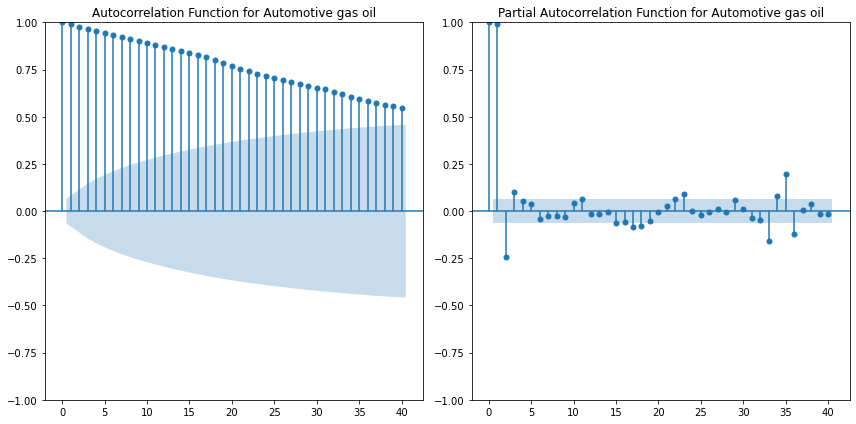

ACF and PACF for Euro-Super 95:


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


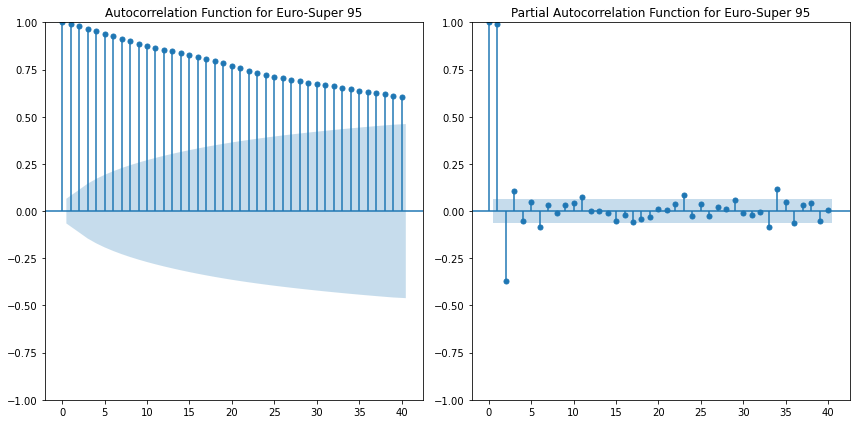

ACF and PACF for Heating gas oil:


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


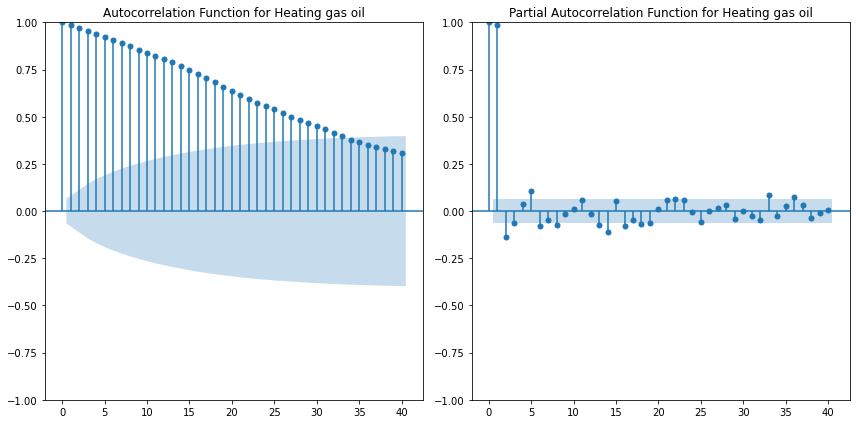

ACF and PACF for Heavy fuel oil:


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


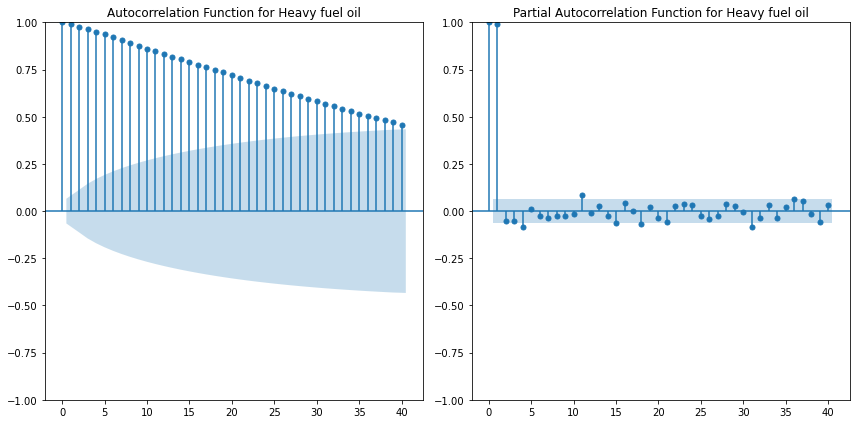

ACF and PACF for LPG:


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


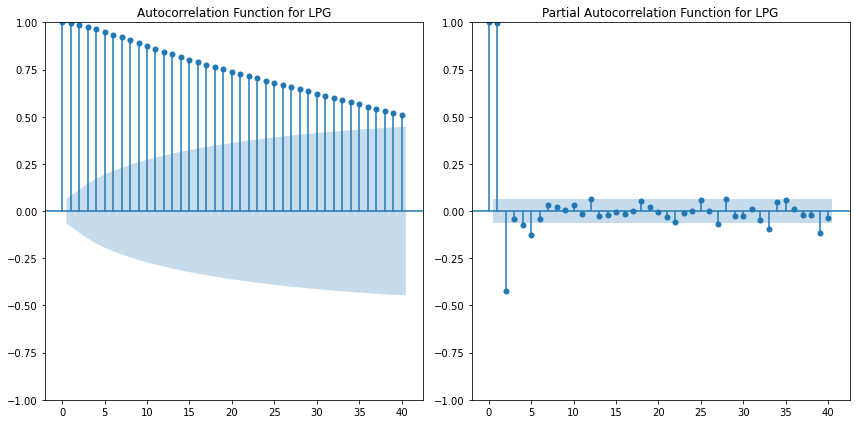

ACF and PACF for Residual fuel oil:


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


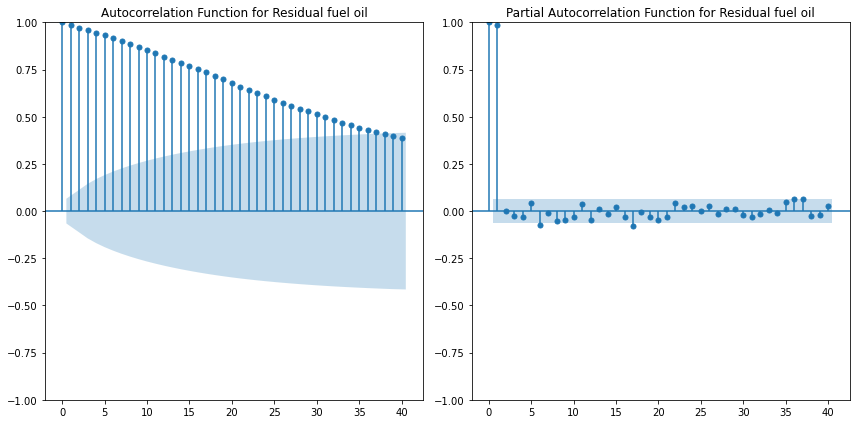

In [6]:
#Plot the anitial ACF and PACF for each fuel type

# Pivot the data
df_pivot = df.pivot_table(index='SURVEY_DATE', columns='PRODUCT_NAME', values='PRICE')

# Calculate and plot ACF and PACF for each fuel type
for fuel_type in df_pivot.columns:
    print(f'ACF and PACF for {fuel_type}:')
    y = df_pivot[fuel_type].dropna()
    
    # Calculate ACF and PACF
    lag_acf = acf(y, nlags=40)
    lag_pacf = pacf(y, nlags=40, method='ols')

    # Plot ACF
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(y, lags=40, ax=plt.gca())
    plt.title(f'Autocorrelation Function for {fuel_type}')

    # Plot PACF
    plt.subplot(122)
    plot_pacf(y, lags=40, ax=plt.gca())
    plt.title(f'Partial Autocorrelation Function for {fuel_type}')

    plt.tight_layout()
    plt.show()

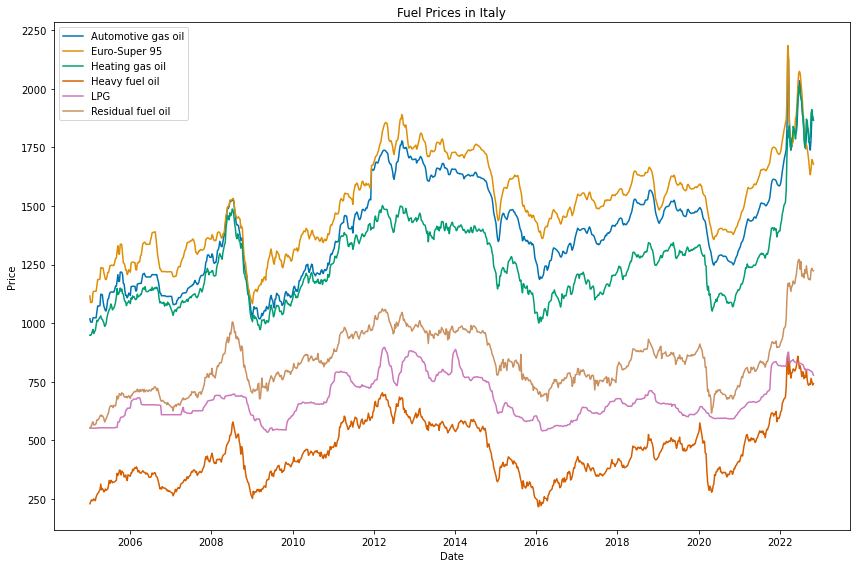

In [7]:
# Define a color palette for each fuel type
colors = sns.color_palette('colorblind', n_colors=len(df_pivot.columns))

# Create a plot for each key in df_pivot
plt.figure(figsize=(12, 8))
for i, key in enumerate(df_pivot):
    plt.plot(df_pivot.index, df_pivot[key], color=colors[i], label=key)
# Add legend and axis labels
plt.legend()

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Fuel Prices in Italy')
plt.tight_layout()
plt.savefig("all_fuels.png")
# Show the plot
plt.show()

In [8]:
# #Our LPG price is clearly non statationary as we can se an upward trend in price. The level and
# #Variability both increasing with time hence, we can surely said there is a large seasonal component
# #with period of 12.

# #We then transform the data into a stationary type using multiple methods

# #Method 1: Box-Cox Transformations

# def boxcox_decompose(ts, graph_title=""):
#     decomposition, lam = boxcox(ts) 
#     # Create a stationary time series by obtaining our residuals from classical decompostion
#     stationary_ts = decomposition

#     # Plot the original time series and its components
#     fig, ax = plt.subplots(1, 2)
#     sns.distplot(ts, hist = False, kde = True,
#             kde_kws = {'shade': True, 'linewidth': 2},
#             label = "Before Box-Cox", color ="blue", ax = ax[0])
#     sns.distplot(stationary_ts, hist = False, kde = True,
#             kde_kws = {'shade': True, 'linewidth': 2},
#             label = "After Box-Cox", color ="green", ax = ax[1])
#     fig.legend(loc = "center right")
#     ax[0].set(title="Probability plot before Box-Cox")
#     ax[1].set(title="Probability plot after Box-Cox")
#     fig.set_figheight(5)
#     fig.set_figwidth(10)
    
#     fig, ax = plt.subplots(1, 2)
#     prob = stats.probplot(ts, dist=stats.norm, plot=ax[0])
#     title="At lambda "
#     title+= str(round(lam,3))
#     ax[0].set(title=title)
#     prob = stats.probplot(stationary_ts, dist=stats.norm, plot=ax[1])
#     ax[1].set(title="")

#     fig.set_figheight(5)
#     fig.set_figwidth(17)

#     plt.tight_layout()

#     return stationary_ts

# # Perform classical decomposition and create a stationary time series for each fuel type
# stationary_boxcox_dict = {}
# for fuel_type in df_pivot.columns:
#     #print(f'Box-Cox Decomposition for {fuel_type}:')
#     gtitle = "Box-Cox Decomposition for "
#     gtitle += fuel_type
#     y = df_pivot[fuel_type].dropna()
#     stationary_boxcox_ts = boxcox_decompose(y,gtitle)
#     stationary_boxcox_dict[fuel_type] = stationary_boxcox_ts

In [9]:
# # Plot the original time series Box-Cox time series
    
# for fuel_type in df_pivot.columns:
#     y = df_pivot[fuel_type].dropna()
#     plt.figure(figsize=(12, 8))
#     plt.subplot(411)
#     plt.plot(y, label='Original')
#     plt.title(fuel_type)
#     plt.legend(loc='upper left')
#     plt.subplot(412)
#     plt.plot(stationary_boxcox_dict[fuel_type], label='Stationary Time Series Box-Cox')
#     plt.legend(loc='upper left')
#     plt.tight_layout()
#     # Plot the stationary time series    
#     plt.show()
    

In [10]:
# #Plot the Box-Cox time-series ACF and PACF
# import warnings
# warnings.filterwarnings('ignore')#Supress warning

# for fuel_type in stationary_boxcox_dict:
#     print(f'Box-Cox ACF and PACF for {fuel_type}:')
#     y = stationary_boxcox_dict[fuel_type]
    
#     # Calculate ACF and PACF
#     lag_acf = acf(y, nlags=40), 
#     lag_pacf = pacf(y, nlags=40, method='ols')

#     # Plot ACF
#     plt.figure(figsize=(12, 6))
#     plt.subplot(121)
#     plot_acf(y, lags=40, ax=plt.gca())
#     plt.title(f'Box-Cox Autocorrelation Function for {fuel_type}')

#     # Plot PACF
#     plt.subplot(122)
#     plot_pacf(y, lags=40, ax=plt.gca())
#     plt.title(f'Box-Cox Partial Autocorrelation Function for {fuel_type}')

#     plt.tight_layout()
#     plt.show()

In [11]:
# def classical_decompose(ts, graph_title="",period=52): #Period =52 represents assumption of yearly seasonality
#     # Perform seasonal decomposition
#     decomposition = seasonal_decompose(ts, period=period, model='additive') #Classical decomposition using linear/quadratic

#     # Extract components
#     trend = decomposition.trend
#     seasonal = decomposition.seasonal
#     residual = decomposition.resid

#     # Create a stationary time series by obtaining our residuals from classical decompostion
#     stationary_ts = residual

#     # Plot the original time series and its components
#     plt.figure(figsize=(12, 8))
#     plt.subplot(411)
#     plt.plot(ts, label='Original')
#     plt.title(graph_title)
#     plt.legend(loc='upper left')
#     plt.subplot(412)
#     plt.plot(trend, label='Trend')
#     plt.legend(loc='upper left')
#     plt.subplot(413)
#     plt.plot(seasonal, label='Seasonality')
#     plt.legend(loc='upper left')
#     plt.tight_layout()

#     # Plot the stationary time series
#     plt.figure(figsize=(12, 4))
#     plt.plot(stationary_ts, label='Stationary Time Series')
#     plt.legend(loc='upper left')
#     plt.show()

#     return stationary_ts

# # Perform classical decomposition and create a stationary time series for each fuel type
# stationary_ts_dict = {}
# for fuel_type in df_pivot.columns:
#     print(f'Seasonal decomposition and stationarization for {fuel_type}:')
#     gtitle = "Seasonal decomposition and stationarization for "
#     gtitle += fuel_type
#     y = df_pivot[fuel_type].dropna()
#     stationary_ts = classical_decompose(y,gtitle)
#     stationary_ts_dict[fuel_type] = stationary_ts

In [12]:
# #Plot the classical time-series ACF and PACF
# import warnings
# warnings.filterwarnings('ignore')#Supress warning

# for fuel_type in stationary_ts_dict:
#     print(f'ACF and PACF for {fuel_type}:')
#     y = df_pivot[fuel_type].dropna()
    
#     # Calculate ACF and PACF
#     lag_acf = acf(y, nlags=40), 
#     lag_pacf = pacf(y, nlags=40, method='ols')

#     # Plot ACF
#     plt.figure(figsize=(12, 6))
#     plt.subplot(121)
#     plot_acf(y, lags=40, ax=plt.gca())
#     plt.title(f'Autocorrelation Function for {fuel_type}')

#     # Plot PACF
#     plt.subplot(122)
#     plot_pacf(y, lags=40, ax=plt.gca())
#     plt.title(f'Partial Autocorrelation Function for {fuel_type}')

#     plt.tight_layout()
#     plt.show()

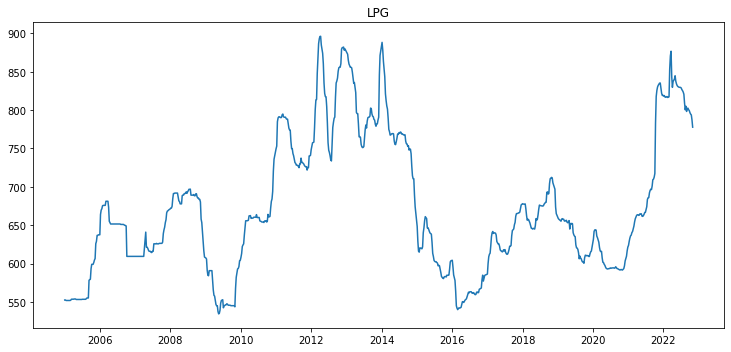

In [13]:
#Analysis of LPG

#Objective: Analyze the data to see which model fit the best, then pick an appropriate forecasting model
#Plot to show the initial time series of Heating gas oil
y = df_pivot["LPG"].dropna()

#Plot initial time series
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.plot(y, label='Price')
plt.title("LPG")
plt.tight_layout()
plt.show()

C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


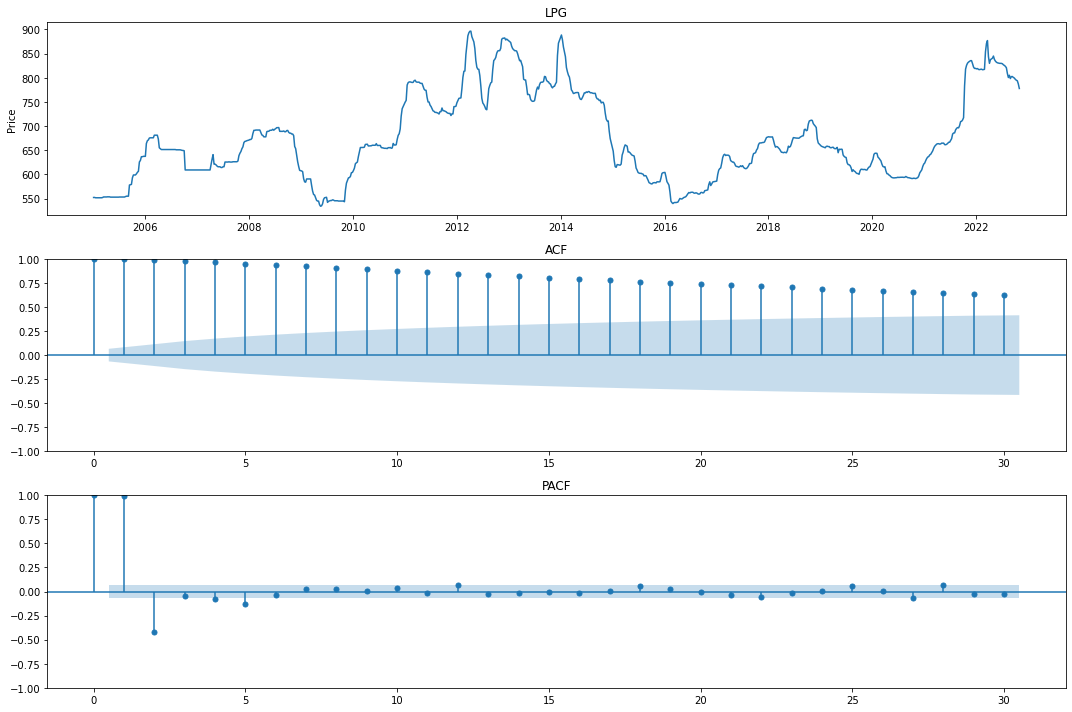

In [14]:
#Analysis of LPG

#Objective: Analyze the data to see which model fit the best, then pick an appropriate forecasting model
#Plot to show the initial time series of Heating gas oil

# Select the Liquified Petroleum Gas series
y = df_pivot['LPG'].dropna()

# Create a figure with two subplots
fig, axs = plt.subplots(3, 1, figsize=(15, 10))

# Plot the time series
axs[0].plot(y)
axs[0].set_ylabel('Price')
axs[0].set_title('LPG')

# Plot the ACF
sm.graphics.tsa.plot_acf(y, lags=30, ax=axs[1])
axs[1].set_title('ACF')

# Plot the PACF
sm.graphics.tsa.plot_pacf(y, lags=30, ax=axs[2])
axs[2].set_title('PACF')

# Adjust the layout and show the plot
plt.tight_layout()
plt.savefig("LPG.png")
plt.show()

Optimal value of d: 1
(1, 0, 2)
(0, 0, 0, 12)


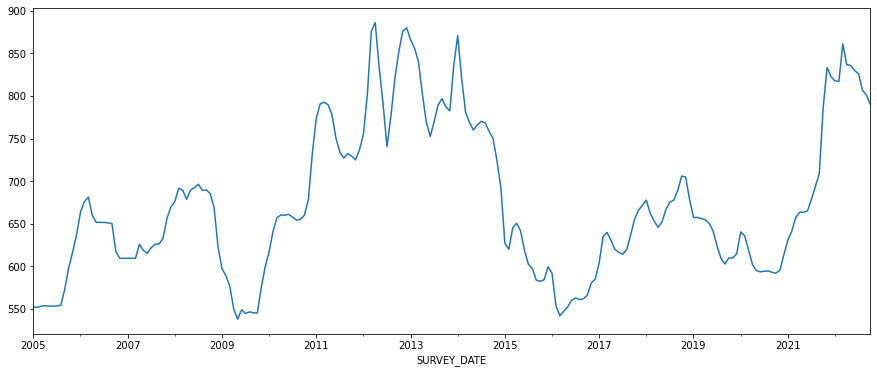

In [15]:
import pmdarima as pm
# determine optimal value of d using pmdarima
d = pm.arima.ndiffs(y, test='adf')  # choose ADF test based on p-value
print(f"Optimal value of d: {d}")

# resampling the daily heating gas oil to a monthly frequency and then computing the monthly averages, we can see the overall 
#trend in price over time with less noise and variability than the daily data.
y_month = y.resample('MS').mean() #'MS' stands for beginning of the month, then taking average over the whole month
y_month.plot(figsize = (15, 6))

# use auto_arima to select optimal parameters for SARIMA model (p,d,q)x(P,D,Q,m)
model = pm.arima.auto_arima(y_month, seasonal=True, m=12)

# print selected SARIMA parameters
print(model.order) #(p,d,q)
print(model.seasonal_order) #(P,D,Q,m)

ADF Statistic AIC: -2.7650356373489346
p-value: 0.0634443497251864
ADF Statistic BIC: -2.7650356373489346
p-value: 0.0634443497251864


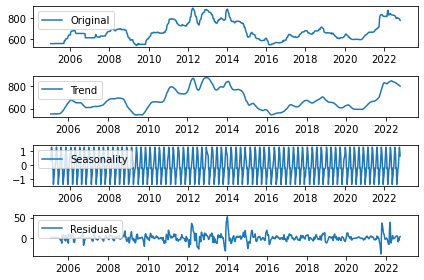

In [16]:
#We see year 2009 - 2020 experience the most upward trend. There is no cyclical pattern to notice.
#This is for sure non-stationary. To ensure our result, we will do a Augmented Dickey-Fuller
#(Unit root test)
#H0: Series is non-stationary; H1: Series is stationary 
# Step 3: Stationarity testing
result = adfuller(y,autolag='AIC')
print(f'ADF Statistic AIC: {result[0]}')
print(f'p-value: {result[1]}')
result3 = adfuller(y,autolag='BIC')
print(f'ADF Statistic BIC: {result3[0]}')
print(f'p-value: {result3[1]}')
#P-value=0.641 which is >0.05, we cannot reject H0. Hence, this is a non-stationary time series.

# Step 4: Time series decomposition
decomposition = seasonal_decompose(y, model='additive', period=12)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(y, label='Original')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper left')
#fig = decomposition.plot() #if want to have a compress view
plt.tight_layout()
plt.show()


C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


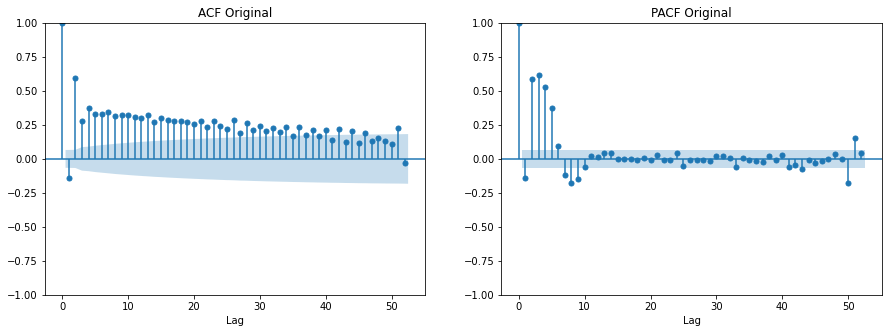

In [52]:
#Analysis of LPG
#Note: Irregular at 2009, hugh crash. then another crash in 2014, then crash in early 2020, follow by 
#Great increase
#Small upward trend in time span of 2 years.
#Plot to show the initial time series of Heating gas oil
y = df_pivot["LPG"].dropna()

# Create ACF and PACF plots of the seasonal differences
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_acf(seasonal_diff, ax=axs[0], lags=52)
axs[0].set(title='ACF Original', xlabel='Lag', ylabel='')

plot_pacf(seasonal_diff, ax=axs[1], lags=52)
axs[1].set(title='PACF Original', xlabel='Lag', ylabel='')
plt.savefig("ACF_PACF.png")
plt.show()
#We see the PACF has value drop instantly while ACF has value decreases gradually, hence we are sure to have 
#seasonal component, using ARIMA

C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


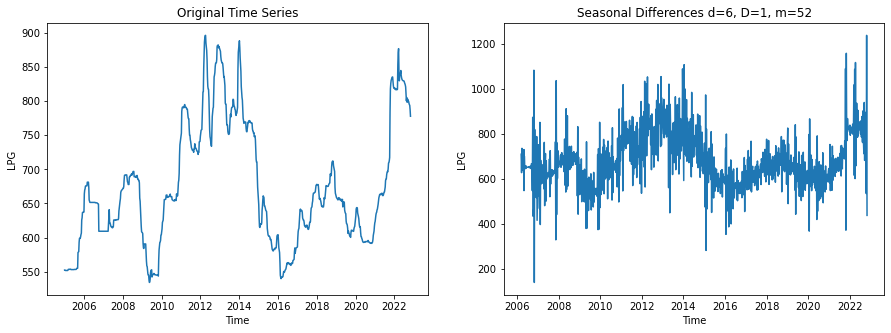

In [18]:
# Fit SARIMA model to time series data
p,d,q = 0,6,0
P,D,Q,m  = 0,1,0,52
model = SARIMAX(df_pivot["LPG"].dropna(), order=(p,d,q), seasonal_order=(P,D,Q,m))
results = model.fit()

# Extract seasonal differences
seasonal_diff = results.get_prediction(dynamic=False).predicted_mean

# Create a figure with two subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Plot original time series in the first subplot
axs[0].plot(df_pivot["LPG"].dropna())
axs[0].set(title='Original Time Series', xlabel='Time', ylabel='LPG')

# Plot seasonal differences in the second subplot
axs[1].plot(seasonal_diff[m+d+1:])
axs[1].set(title='Seasonal Differences d=6, D=1, m=52', xlabel='Time', ylabel='LPG')

# Display the figure
# plt.savefig("Eye-Ball")
plt.show()

C:\Users\caoti\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


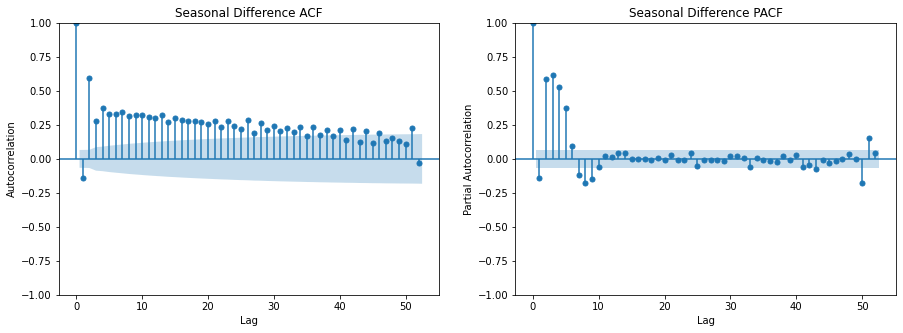

In [19]:
# Create ACF and PACF plots of the seasonal differences
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

plot_acf(seasonal_diff, ax=axs[0], lags=52)
axs[0].set(title='Seasonal Difference ACF', xlabel='Lag', ylabel='Autocorrelation')

plot_pacf(seasonal_diff, ax=axs[1], lags=52)
axs[1].set(title='Seasonal Difference PACF', xlabel='Lag', ylabel='Partial Autocorrelation')
# plt.savefig("SeasonalEyeBall.png")
plt.show()

In [20]:
# The test run for a long time and easily explode memory, only run if's ensure
# Specify the range of values for p, d, q, P, D, Q, and S
# start_p, d, start_q = 1, 5, 1
# start_P, D, start_Q, m = 2, 1, 1, 52

# # Use the auto_arima function to find the best parameters for the SARIMA model
# model = pm.auto_arima(y, start_p=start_p, d=d, start_q=start_q, max_p=3, max_d=6, max_q=3,
#                    start_P=start_P, D=D, start_Q=start_Q, max_P=3, max_D=3, max_Q=3, m=m,
#                    seasonal=True, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)

# # Print the best model parameters
# print(model.order)
# print(model.seasonal_order)

In [32]:
# Fit SARIMA model using auto_arima
model_test = pm.auto_arima(y, seasonal=True, m=52, stepwise=True, suppress_warnings=True, error_action='ignore')
# Print the best model parameters
print(f"Here is the non_seasonal order p,d,q: {model_test.order}")
print(f"Here is the seasonal order P,D,Q,m: {model_test.seasonal_order}")
#This order is not used in later analysis because the model has poor predictive power

Here is the non_seasonal order p,d,q: (1, 1, 0)
Here is the seasonal order P,D,Q,m: (0, 0, 0, 52)


In [21]:
# #Test for AR Invertible
# if results.arroots.real.max() > 1:
#     print("AR polynomial is not invertible")
# else:
#     print("AR polynomial is invertible")

In [31]:
#Test statistic for AUTO_ARIMA model
p,d,q = 1,1,0
P,D,Q,m = 0,0,0,52
# set the frequency of the date index to weekly
y.index = pd.date_range(start=y.index.min(), periods=len(y), freq='W')
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size-1:]
# fit the SARIMA model on the training data
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                    LPG   No. Observations:                  714
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -2327.946
Date:                Thu, 04 May 2023   AIC                           4659.893
Time:                        20:29:45   BIC                           4669.032
Sample:                    01-09-2005   HQIC                          4663.423
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4936      0.023     21.264      0.000       0.448       0.539
sigma2        40.1143      0.786     51.063      0.000      38.575      41.654
Ljung-Box (L1) (Q):                   0.15   Jarque-

In [44]:
#Manually pick order for SARIMA model, which is better under AIC, BIC criteria
p,d,q = 1,1,2
P,D,Q,m = 0,1,1,52
# set the frequency of the date index to weekly
y.index = pd.date_range(start=y.index.min(), periods=len(y), freq='W')
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size-1:]
# fit the SARIMA model on the training data
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, m))
result = model.fit()


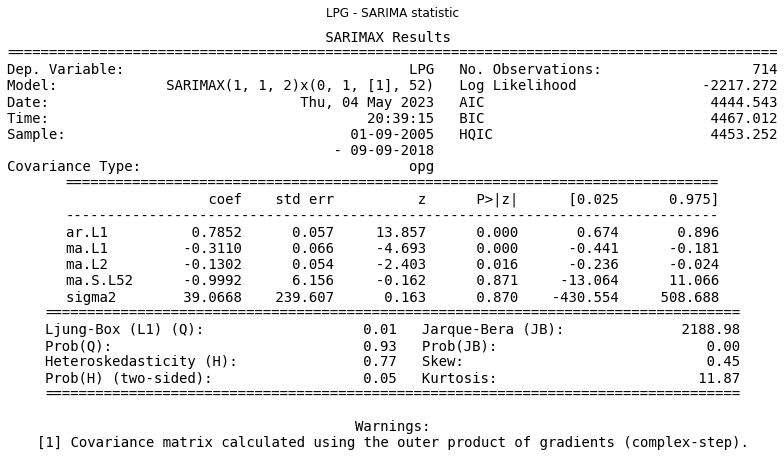

In [48]:
#Print and save statistic result of the model
# Get the statistical summary
summary = result.summary()

# Convert summary table to string
table_text = summary.as_text()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10,8))

# Hide axis and plot the summary table as text
ax.axis('off')
ax.text(0.5, 0.5, table_text, va='center', ha='center', fontsize=14, family='monospace')
ax.set_title('LPG - SARIMA statistic')
# Plot the summary table
plt.show()
# Save the table figure as an image
fig.savefig('lpg_summary.png')

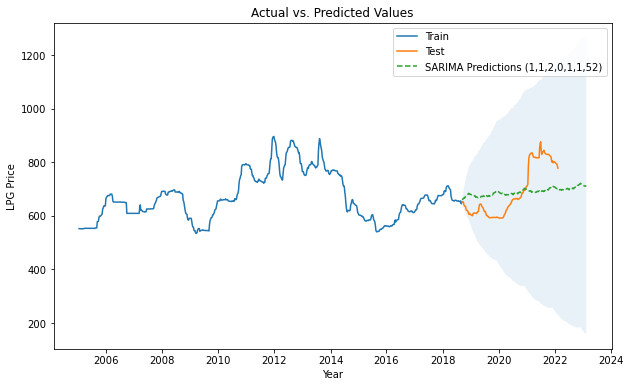

In [60]:
#Step 6: Make predictions 
#
forecast_original = result.get_forecast(steps=len(test))
pred_original = forecast_original.predicted_mean

# make predictions on the test data and future data
forecast = result.get_forecast(steps=len(test) + m)
pred = forecast.predicted_mean
conf_int = forecast.conf_int()

# plot the train and test data along with the predicted values and confidence interval
plt.figure(figsize=(10,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label=f'SARIMA Predictions ({p},{d},{q},{P},{D},{Q},{m})', linestyle='--')
plt.fill_between(conf_int.index, conf_int['lower LPG'], conf_int['upper LPG'], alpha=0.1)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('LPG Price')
plt.title('Actual vs. Predicted Values')
plt.legend()
# plt.savefig("SARIMA_Forecast")
plt.show()

In [62]:
#Evaluate our model
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define a function to calculate the metrics
def evaluate(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    return {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape}
            
# Evaluate the model's performance using the defined function
metrics = evaluate(test, pred_original)

# Print the metrics in a table
print("{:<10} {:<10}".format('Metric', 'Value'))
print("="*25)
for key, value in metrics.items():
    print("{:<10} {:<10.4f}".format(key, value))

Metric     Value     
MSE        7553.1656 
RMSE       86.9090   
MAE        75.3019   
MAPE       10.6876   
SMAPE      10.7734   


In [77]:
#Another code to create table metrics
def create_metric_table(y_true, y_pred):
    # calculate the metrics for each model
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    smape = np.mean(2.0 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100
    
    # create the metric table
    metric_table = pd.DataFrame({
        'MSE': [mse],
        'RMSE': [rmse],
        'MAE': [mae],
        'MAPE': [mape],
        'SMAPE': [smape],
    }, index=['LPG - SARIMA'])
    return metric_table
# Evaluate the model's performance using the defined function
metrics = create_metric_table(test, pred_original)
print(metrics)
# # plot the table as a figure
# fig, ax = plt.subplots(figsize=(10, 3))
# ax.axis('off')
# ax.axis('tight')
# ax.table(cellText=metrics.values, colLabels=metrics.columns, rowLabels=metrics.index, loc='center')
# ax.set_title('SARIMA Model Metrics')
# fig.tight_layout()
# #     fig.savefig('metric_table.png')
# fig.show()


                      MSE      RMSE        MAE       MAPE      SMAPE
LPG - SARIMA  7553.165619  86.90895  75.301907  10.687625  10.773422
